# Learnable activation functions
**Name**: Enikő Palencsár \
**Neptune**: YD11NL \
**Course**: Geometric modelling and applications \
**Description**: Implement simple neural networks with different learnable activation functions, chosen from the approximation and interpolation curves we learnt about in class. Observe their performance, strengths, weaknesses.

In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

## General function for training loop

In [132]:
def train_model(model, x_train, y_train, optimizer, loss_fn, epochs: int = 1000, info_frequency: int = 50):
    """Training loop for PyTorch model
    
    Arguments: model, training features, expected output features, optimizer, 
    loss function, number of epoch to run, number of epochs on which loss info should be printed.
    Returns list of training loss values per epoch.
    """
    assert(epochs > 0 and info_frequency > 0), "Epoch number and info frequency must be positive."
    losses = []
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(x_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
        # Print loss occasionally
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return losses

## General functions for loss and activation function visualization

In [133]:
def visualize_activation(title, activation, x_train, y_train = None):
    with torch.no_grad():
        y = activation(x_train)
    
    plt.figure(figsize=(8, 4))
    
    # Plot the learned activation function
    plt.plot(x_train.numpy(), y.numpy(), label='Learned activation function', color='blue')
    
    # Plot the training data points
    if y_train is not None:
        plt.plot(x_train.numpy(), y_train.numpy(), label='Training data', color='green')
    
    plt.title(title)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.grid(True)
    plt.legend()
    plt.show()

In [134]:
def visualize_loss(title, losses):
    plt.figure(figsize=(12, 5))
    plt.plot(losses, label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

## Class for a B-spline activation function
* Initialization of trainable parameters (control points)
* Knots uniformly distributed over $[0, 1]$ (could be trainable too, with monotonity condition)
* Forward pass definition
    * Scale inputs to be inside the interval $[u_{k-1}, u_{n+1}]$
    * Calculate the tensor of basis functions for the input as a matrix
    * Multiply each inner matrix with the corresponding knot value
    * Sum the corresponding elements of the resulting matrices, get a matrix with the input's dimensions
    * Be eternally happy

In [135]:
class BSplineActivation(nn.Module):
    def __init__(self, degree: int, control_point_num: int):
        super(BSplineActivation, self).__init__()
        self.degree = degree
        self.control_point_num = control_point_num
        # Randomize control points and make them learnable
        self.control_points = nn.Parameter(torch.randn(control_point_num))
        # Let the knots be uniformly distributed over the interval [0, 1]
        self.knots = torch.linspace(0, 1, control_point_num + degree + 1)

    def forward(self, x):
        # Scale the input into the interval of the knots
        x = self.scale_to_interval(x, self.knots[self.degree], self.knots[-self.degree-1])
        basis = self.basis_functions(x)
        sum_members = basis * self.control_points.view(self.control_point_num, 1, 1)
        result = torch.sum(sum_members, dim=0)
        return result

    def scale_to_interval(self, x, min_val, max_val):
        x_min, x_max = x.min(), x.max()
        x_scaled = min_val + (x - x_min) * (max_val - min_val) / (x_max - x_min)
        return x_scaled

    def basis_functions(self, x):
        k = self.degree
        # Store the i-th k-rank normalized B-spline bases for all elements of x
        basis = torch.zeros((self.control_point_num, x.shape[0], x.shape[1]))
        for i in range(0, self.control_point_num):
            basis[i] = self.basis_function(x, i, k)
        return basis

    def basis_function(self, x, i, k):
        if k == 1:
            return ((self.knots[i] <= x) & (x < self.knots[i+1])).float()
        else:
            coeff1 = (x - self.knots[i])/(self.knots[i+k-1]-self.knots[i])
            coeff2 = (self.knots[i + k] - x)/(self.knots[i+k]-self.knots[i+1])
            return coeff1 * self.basis_function(x, i, k-1) + coeff2 * self.basis_function(x, i+1, k-1)

### A simple test for the activation layer

In [136]:
linear = nn.Linear(1, 2)
activation = BSplineActivation(degree=3, control_point_num=10)
input = torch.linspace(0, 1, 5).unsqueeze(1)
x = linear(input)
x = activation(x)
input.shape, input, x.shape, x

(torch.Size([5, 1]),
 tensor([[0.0000],
         [0.2500],
         [0.5000],
         [0.7500],
         [1.0000]]),
 torch.Size([5, 2]),
 tensor([[ 0.4381, -0.0448],
         [ 0.2700,  0.2098],
         [-0.1180,  1.2123],
         [-0.1954,  0.5559],
         [ 0.1242,  0.3531]], grad_fn=<SumBackward1>))

## A minimal network with learnable B-spline activation
Practically a simple B-spline approximation problem to be solved using backpropagation.

In [137]:
class BSplineNN(nn.Module):
    def __init__(self, degree, control_point_num):
        super(BSplineNN, self).__init__()
        self.input_layer = nn.Linear(1, 1)
        # self.hidden_layer = nn.Linear(64, 64)
        self.output_layer = nn.Linear(1, 1)
        self.activation = BSplineActivation(degree=degree, control_point_num=control_point_num)
        # Disable weights and biases in linear layers
        self.initialize_weights()
    
    def initialize_weights(self):
        with torch.no_grad():
            # Setting weights to 1 and making them non-trainable
            for layer in [self.input_layer, self.output_layer]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

## Generation of synthetic training data (sine function)

In [138]:
x_train = torch.linspace(0, 1, 200).unsqueeze(1)
y_train = torch.sin(2 * np.pi * x_train)

## Training

In [139]:
# Initialize model
bspline_model = BSplineNN(degree=3, control_point_num=10)

# Optimizer
optimizer = optim.Adam(bspline_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses = train_model(bspline_model, x_train, y_train, optimizer, loss_fn, epochs = 500, info_frequency = 50)

Epoch [50/500], Loss: 0.4082
Epoch [100/500], Loss: 0.1423
Epoch [150/500], Loss: 0.0459
Epoch [200/500], Loss: 0.0148
Epoch [250/500], Loss: 0.0056
Epoch [300/500], Loss: 0.0027
Epoch [350/500], Loss: 0.0015
Epoch [400/500], Loss: 0.0009
Epoch [450/500], Loss: 0.0006
Epoch [500/500], Loss: 0.0003


## Plot loss

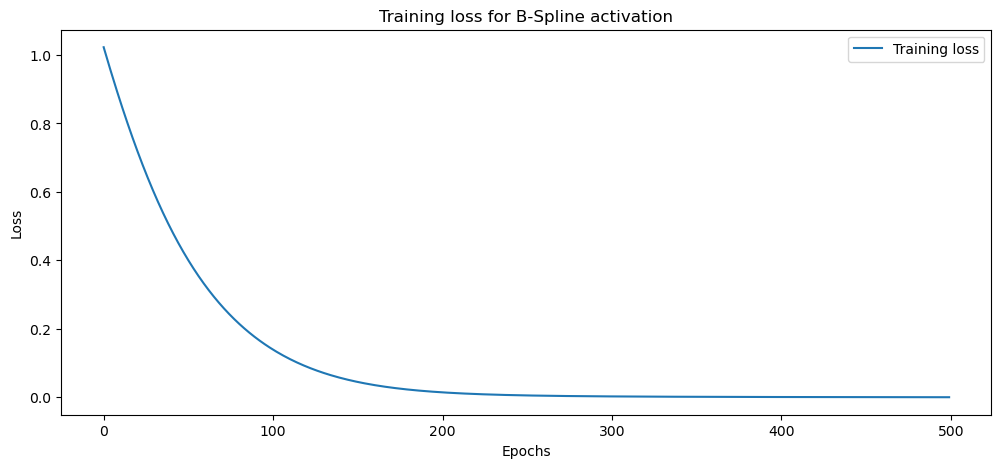

In [140]:
visualize_loss("Training loss for B-Spline activation", losses)

## Visualize the trained activation function
If weights stay on in the linear layers, this constitutes an excellent example of how non-linearities work. The B-spline has the same shape as the original curve, but it's shifted/mirrored. The leftover weights in the linear layers allow it to be transformed linearly without compromising the loss of the network. \
In a network with more neurons, more severe deformations will occur because of the different combinations of weights.

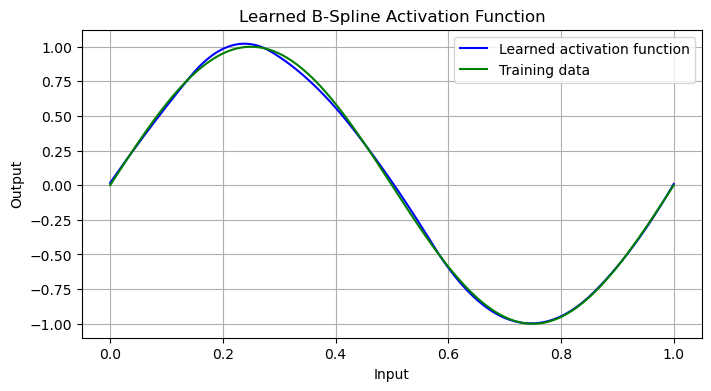

In [141]:
# Visualize Learned Activation
visualize_activation("Learned B-Spline Activation Function", bspline_model.activation, x_train, y_train)

## Inspect model structure

In [142]:
summary(bspline_model, input_size=[1,1])

Layer (type:depth-idx)                   Output Shape              Param #
BSplineNN                                [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    (2)
├─BSplineActivation: 1-2                 [1, 1]                    10
├─Linear: 1-3                            [1, 1]                    (2)
Total params: 14
Trainable params: 10
Non-trainable params: 4
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Class for NURBS activation function

In [143]:
class NURBSActivation(nn.Module):
    def __init__(self, degree: int, control_point_num: int):
        super(NURBSActivation, self).__init__()
        self.degree = degree
        self.control_point_num = control_point_num
        # Randomize control points and make them learnable
        self.control_points = nn.Parameter(torch.randn(control_point_num))
        self.weights = nn.Parameter(torch.ones(control_point_num))
        # Let the knots be uniformly distributed over the interval [0, 1]
        self.knots = torch.linspace(0, 1, control_point_num + degree + 1)

    def forward(self, x):
        # Scale the input into the interval of the knots
        x = self.scale_to_interval(x, self.knots[self.degree], self.knots[-self.degree-1])
        basis = self.basis_functions(x)
        sum_members = self.weights.view(self.control_point_num, 1, 1) * basis * self.control_points.view(self.control_point_num, 1, 1)
        result = torch.sum(sum_members, dim=0)
        denominator = torch.sum(self.weights.view(self.control_point_num, 1, 1) * basis, dim=0) + 1e-6
        return result / denominator

    def scale_to_interval(self, x, min_val, max_val):
        x_min, x_max = x.min(), x.max()
        x_scaled = min_val + (x - x_min) * (max_val - min_val) / (x_max - x_min)
        return x_scaled

    def basis_functions(self, x):
        k = self.degree
        # Store the i-th k-rank normalized B-spline bases for all elements of x
        basis = torch.zeros((self.control_point_num, x.shape[0], x.shape[1]))
        for i in range(0, self.control_point_num):
            basis[i] = self.basis_function(x, i, k)
        return basis

    def basis_function(self, x, i, k):
        if k == 1:
            return ((self.knots[i] <= x) & (x < self.knots[i+1])).float()
        else:
            coeff1 = (x - self.knots[i])/(self.knots[i+k-1]-self.knots[i])
            coeff2 = (self.knots[i + k] - x)/(self.knots[i+k]-self.knots[i+1])
            return coeff1 * self.basis_function(x, i, k-1) + coeff2 * self.basis_function(x, i+1, k-1)

### Check NURBS activation function
If weights are uniformly 1, forward pass should lead to the same result as BSplineActivation's forward pass given that the control points are the same.

In [144]:
nurbs_activation = NURBSActivation(degree=3, control_point_num=10)
bspline_activation = BSplineActivation(degree=3, control_point_num=10)
nurbs_activation.weights = nn.Parameter(torch.ones(10))
bspline_activation.control_points = nurbs_activation.control_points

input = torch.linspace(0, 1, 5).unsqueeze(1)

x = nurbs_activation(input)
x2 = bspline_activation(input)

input, x, x2

(tensor([[0.0000],
         [0.2500],
         [0.5000],
         [0.7500],
         [1.0000]]),
 tensor([[-0.6847],
         [ 1.5653],
         [-0.4863],
         [ 1.7156],
         [-0.8221]], grad_fn=<DivBackward0>),
 tensor([[-0.6847],
         [ 1.5653],
         [-0.4863],
         [ 1.7156],
         [-0.8221]], grad_fn=<SumBackward1>))

## A minimal network with learnable NURBS activation

In [145]:
class NURBSNN(nn.Module):
    def __init__(self, degree, control_point_num):
        super(NURBSNN, self).__init__()
        self.input_layer = nn.Linear(1, 1)
        self.output_layer = nn.Linear(1, 1)
        self.activation = NURBSActivation(degree=degree, control_point_num=control_point_num)
        # Disable weights and biases in linear layers
        self.initialize_weights()
        
    def initialize_weights(self):
        with torch.no_grad():
            # Setting weights to 1 and making them non-trainable
            for layer in [self.input_layer, self.output_layer]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

## Training

In [146]:
# Initialize model
nurbs_model = NURBSNN(degree=3, control_point_num=10)

# Optimizer
optimizer = optim.Adam(nurbs_model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

losses = train_model(nurbs_model, x_train, y_train, optimizer, loss_fn, epochs = 1000, info_frequency = 50)

Epoch [50/1000], Loss: 0.0054
Epoch [100/1000], Loss: 0.0022
Epoch [150/1000], Loss: 0.0017
Epoch [200/1000], Loss: 0.0015
Epoch [250/1000], Loss: 0.0013
Epoch [300/1000], Loss: 0.0012
Epoch [350/1000], Loss: 0.0012
Epoch [400/1000], Loss: 0.0011
Epoch [450/1000], Loss: 0.0011
Epoch [500/1000], Loss: 0.0011
Epoch [550/1000], Loss: 0.0010
Epoch [600/1000], Loss: 0.0010
Epoch [650/1000], Loss: 0.0010
Epoch [700/1000], Loss: 0.0009
Epoch [750/1000], Loss: 0.0009
Epoch [800/1000], Loss: 0.0009
Epoch [850/1000], Loss: 0.0009
Epoch [900/1000], Loss: 0.0008
Epoch [950/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0007


### Loss

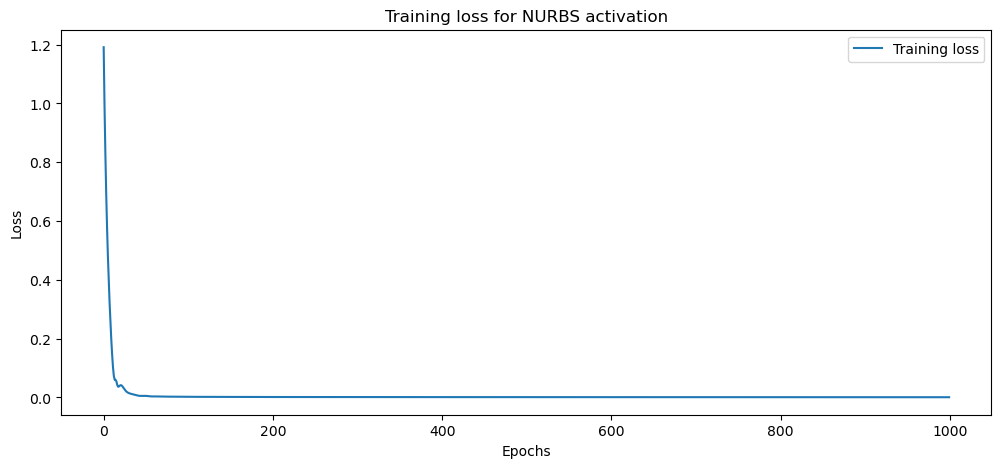

In [147]:
visualize_loss("Training loss for NURBS activation", losses)

### Model structure

In [148]:
summary(nurbs_model, input_size=[1,1])

Layer (type:depth-idx)                   Output Shape              Param #
NURBSNN                                  [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    (2)
├─NURBSActivation: 1-2                   [1, 1]                    20
├─Linear: 1-3                            [1, 1]                    (2)
Total params: 24
Trainable params: 20
Non-trainable params: 4
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Function learned

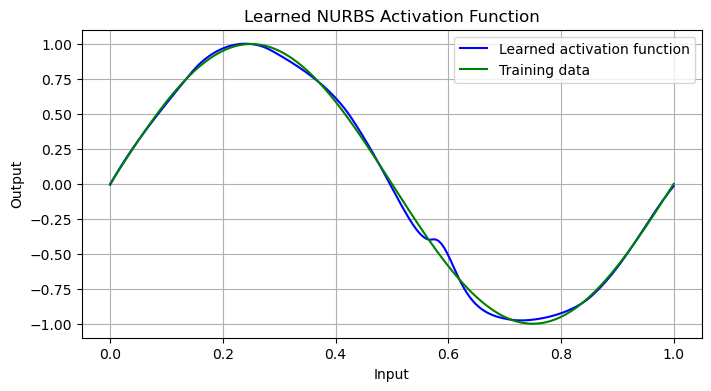

In [149]:
# Visualize Learned Activation
visualize_activation("Learned NURBS Activation Function", nurbs_model.activation, x_train, y_train)

## Class for Lagrange activation function

In [150]:
class LagrangeActivation(nn.Module):
    def __init__(self, degree: int):
        super(LagrangeActivation, self).__init__()
        self.degree = degree
        # Randomize interpolation points (y values) and make them learnable
        self.interpolation_points = nn.Parameter(torch.randn(degree + 1))
        self.u_values = torch.linspace(-1, 1, degree + 1)

    def forward(self, x):
        self.u_values = torch.linspace(x.min(), x.max(), self.degree + 1)
        lagrange = self.lagrangePolynomial(x) / self.lagrangePolynomialDenominator()
        return torch.sum(lagrange * self.interpolation_points, axis=-1)

    def lagrangePolynomialDenominator(self):
        u_i = self.u_values.unsqueeze(0)
        u_j = self.u_values.unsqueeze(1)
        
        # Create nxn self-difference matrix for u_values
        diff = u_i - u_j
        
        # The difference should not be part of the product if i = j (is then 0)
        # So the diagonal should be switched from containing all zeros, to all ones (ones do not affect the product)
        diff.fill_diagonal_(1.0)

        # Return list of Lagrange denominators (products of all self-differences in a row)
        return torch.prod(diff, axis=-1);

    def lagrangePolynomial(self, x):
        # Add 2 dimensions to the last dimension of x
        x_expanded = x.unsqueeze(-1).unsqueeze(-1)

        # u_values is a 1d array, get element count
        n = self.u_values.shape[0]

        # Expand u_values into a nxn matrix such that each row of the mx is u_values
        u_expanded = self.u_values.unsqueeze(0).expand(n, -1)

        # Create a mask using the negated nxn identity matrix
        mask = ~torch.eye(n, dtype=torch.bool, device=self.u_values.device)

        # Delete the main diagonal values from u_expanded, using the mask
        u_expanded = u_expanded[mask].view(n, n - 1)

        # Elements of diff contain an n*n-1 matrix for every x, the elements of the Lagrange polynomial products in the nominator
        diff = x_expanded - u_expanded

        # Return with the products aka inner row sums
        return torch.prod(diff, axis=-1);

### Check activation function shape (should be given degree polynomial)

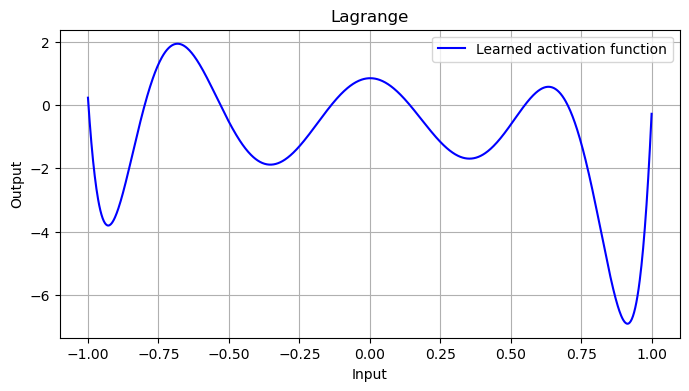

In [151]:
degree = 8
act = LagrangeActivation(degree)
visualize_activation("Lagrange", act, torch.linspace(-1, 1, 1000))

## Minimal network with Lagrange activation

In [152]:
class LagrangeNN(nn.Module):
    def __init__(self, degree):
        super(LagrangeNN, self).__init__()
        self.input_layer = nn.Linear(1, 1)
        self.output_layer = nn.Linear(1, 1)
        self.activation = LagrangeActivation(degree=degree)
        # Disable weights and biases in linear layers
        self.initialize_weights()
        
    def initialize_weights(self):
        with torch.no_grad():
            # Setting weights to 1 and making them non-trainable
            for layer in [self.input_layer, self.output_layer]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

## Training loop

In [153]:
# Initialize model
lagrange_model = LagrangeNN(degree=3)

# Optimizer
optimizer = optim.Adam(lagrange_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses = train_model(lagrange_model, x_train, y_train, optimizer, loss_fn, epochs = 1000, info_frequency = 50)

Epoch [50/1000], Loss: 0.6651
Epoch [100/1000], Loss: 0.2389
Epoch [150/1000], Loss: 0.0785
Epoch [200/1000], Loss: 0.0259
Epoch [250/1000], Loss: 0.0107
Epoch [300/1000], Loss: 0.0065
Epoch [350/1000], Loss: 0.0052
Epoch [400/1000], Loss: 0.0048
Epoch [450/1000], Loss: 0.0046
Epoch [500/1000], Loss: 0.0046
Epoch [550/1000], Loss: 0.0046
Epoch [600/1000], Loss: 0.0046
Epoch [650/1000], Loss: 0.0046
Epoch [700/1000], Loss: 0.0046
Epoch [750/1000], Loss: 0.0046
Epoch [800/1000], Loss: 0.0046
Epoch [850/1000], Loss: 0.0046
Epoch [900/1000], Loss: 0.0046
Epoch [950/1000], Loss: 0.0046
Epoch [1000/1000], Loss: 0.0046


### Plot loss curve

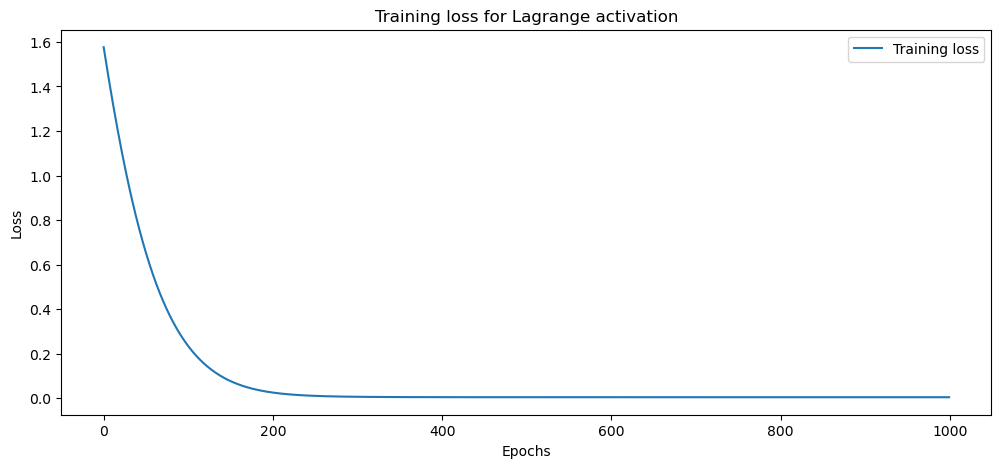

In [154]:
visualize_loss("Training loss for Lagrange activation", losses)

### Visualize learned activation

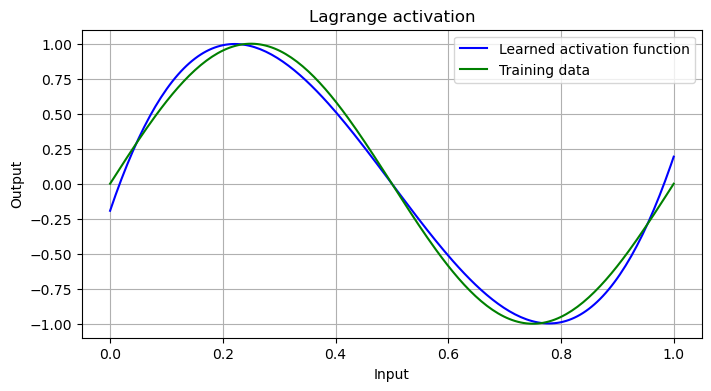

In [155]:
visualize_activation("Lagrange activation", lagrange_model.activation, x_train, y_train)

### View model structure

In [156]:
summary(lagrange_model, input_size=[1,1])

Layer (type:depth-idx)                   Output Shape              Param #
LagrangeNN                               [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    (2)
├─LagrangeActivation: 1-2                [1, 1]                    4
├─Linear: 1-3                            [1, 1]                    (2)
Total params: 8
Trainable params: 4
Non-trainable params: 4
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Remains to be seen

* Do we need weights on edges if we have learnable activation functions?
    * For now, weights are turned off, later, we will see.
* Should knots be uniformly distributed or something else?
* How to initialize activation curve parameters?
    * For now, torch.randn is used in most cases, so there is random sampling from a normal distribution
    * For NURBS, B-spline type initialization seems to yield the best results (random points, uniformly 1 weights)
* Performance compared to ReLU (for same number of params)
* Performance in a more complex task e.g. image classification after CNN and flattening